In [ ]:
import yfinance
import pandas as pd
import numpy as np

# Gerekli veriyi çekiyoruz
df = pd.read_csv("all_companies_balance_statements.csv")
df2 = pd.read_csv("all_companies_cashflow_statements.csv")
df3 = pd.read_csv("all_companies_income_statements.csv")
df4 = pd.read_excel("listof90year.xlsx")

# List of 90 yearsa melt atıp tip değiştiriyoruz
df4 = (
    pd.melt(df4, id_vars="year")          
      [["year", "value"]]                
      .dropna()                          
)
df4["year"] = df4["year"].astype(str).str.strip()   

# Prefixler ekleyerek verilerin ne olduğunu ekliyoruz
df_bs = df.add_prefix('bs_')
df_cf = df2.add_prefix('cf_')
df_is = df3.add_prefix('is_')
for dfx in [df, df2, df3]:
    dfx['symbol'] = dfx['symbol'].astype(str).str.strip().str.upper()
    dfx['calendarYear'] = dfx['calendarYear'].astype(str).str.strip()
    dfx['period'] = dfx['period'].astype(str).str.strip().str.upper()

# Join key'leri ekleyip mergelüyoruz
for col in ['symbol', 'calendarYear', 'period']:
    df_bs[col] = df[col]
    df_cf[col] = df2[col]
    df_is[col] = df3[col]
combined_df = df_bs.merge(df_cf, on=['symbol', 'calendarYear', 'period'], how='outer')
combined_df = combined_df.merge(df_is, on=['symbol', 'calendarYear', 'period'], how='outer')

# Buradaki outer merge işini çözemedim innerda veri kaybı yaşanıyor
# Eskiden adı farklı olan şirketler için bir dict var mı?  
# df4 tickerlarının structure'u güzel değil düzeltilip farklı yapılır
# FMP'den yıl bazlı ratio çekebilirsek daha da iyi olabilir
# S&P500 dışı işlemlere adaptasyonda sorunlar olucak raw data ona göre
# Nasdaq için düzenli excel dışı FMP'den veri çeken sistem daha iyi
# Yeni ratiolar eklendi ama gereksiz olanlar var
# N/A leri meltle ya da başka yolla sıfırlamam kötü etki ediyor sanırım
# Random forest yerine yapılan ratio şeyinde hatalar var rankingte

In [51]:
combined_df

,bs_Symbol,bs_Unnamed: 1,bs_date,bs_symbol,bs_reportedCurrency,bs_cik,bs_fillingDate,bs_acceptedDate,bs_calendarYear,bs_period,...,debt_to_equity,debt_to_assets,longterm_debt_to_equity,operating_cf_to_netincome,free_cf_to_assets,free_cf_to_equity,market_price,shares_outstanding,market_cap,tobins_q
0,A,26.0,1998-10-31,A,USD,1090872.0,1998-10-31,1998-10-31 00:00:00,1998.0,FY,...,0.6502,0.3940,0.0000,2.9222,0.0684,0.1128,NaN,NaN,NaN,NaN
1,A,25.0,1999-10-31,A,USD,1090872.0,2000-01-25,2000-01-25 00:00:00,1999.0,FY,...,0.6097,0.3788,0.0000,0.9004,0.0050,0.0080,NaN,NaN,NaN,NaN
2,A,24.0,2000-10-31,A,USD,1090872.0,2001-01-17,2001-01-17 00:00:00,2000.0,FY,...,0.6002,0.3751,0.0000,1.1070,0.0017,0.0027,NaN,NaN,NaN,NaN
3,A,23.0,2001-10-31,A,USD,1090872.0,2002-01-22,2002-01-22 00:00:00,2001.0,FY,...,0.4112,0.2914,0.0000,8.9405,0.0778,0.1097,NaN,NaN,NaN,NaN
4,A,22.0,2002-10-31,A,USD,1090872.0,2002-12-20,2002-12-20 17:27:53,2002.0,FY,...,0.7729,0.4359,0.2485,0.4826,-0.0974,-0.1727,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153375,ZYXI,4.0,2019-12-31,ZYXI,USD,846475.0,2020-02-27,2020-02-27 17:24:43,2019.0,FY,...,0.4368,0.3050,0.1736,0.6640,0.2172,0.3112,NaN,NaN,NaN,NaN
153376,ZYXI,3.0,2020-12-31,ZYXI,USD,846475.0,2021-02-25,2021-02-25 17:01:35,2020.0,FY,...,0.2695,0.2123,0.0915,0.0901,-0.0023,-0.0029,NaN,NaN,NaN,NaN
153377,ZYXI,2.0,2021-12-31,ZYXI,USD,846475.0,2022-03-22,2022-03-21 19:19:49,2021.0,FY,...,0.8028,0.4453,0.3622,0.4063,0.0476,0.0858,NaN,NaN,NaN,NaN
153378,ZYXI,1.0,2022-12-31,ZYXI,USD,846475.0,2023-03-14,2023-03-13 18:49:43,2022.0,FY,...,0.7551,0.4302,0.2867,0.8063,0.1144,0.2008,NaN,NaN,NaN,NaN


In [ ]:
# Ratiolar oluşturuyoruz
combined_df['gross_margin']            = combined_df['is_grossProfit']           / combined_df['is_revenue']
combined_df['net_margin']              = combined_df['is_netIncome']             / combined_df['is_revenue']
combined_df['operating_margin']        = combined_df['is_operatingIncome']       / combined_df['is_revenue']
# ROA değişebilir
combined_df['ROA']                     = combined_df['is_netIncome']             / combined_df['bs_totalAssets']
combined_df['ROE']                     = combined_df['is_netIncome']             / combined_df['bs_totalStockholdersEquity']
combined_df['ebitda_margin']           = combined_df['is_ebitda']                / combined_df['is_revenue']
combined_df['current_ratio']           = combined_df['bs_totalCurrentAssets']    / combined_df['bs_totalCurrentLiabilities']
combined_df['quick_ratio']             = (combined_df['bs_cashAndShortTermInvestments'] +
                                          combined_df['bs_netReceivables'])      / combined_df['bs_totalCurrentLiabilities']
combined_df['asset_turnover']          = combined_df['is_revenue']               / combined_df['bs_totalAssets']
combined_df['receivables_turnover']    = combined_df['is_revenue']               / combined_df['bs_netReceivables']
combined_df['inventory_turnover']      = combined_df['is_costOfRevenue']         / combined_df['bs_inventory']
combined_df['debt_to_equity']          = combined_df['bs_totalLiabilities']      / combined_df['bs_totalStockholdersEquity']
combined_df['debt_to_assets']          = combined_df['bs_totalLiabilities']      / combined_df['bs_totalAssets']
combined_df['longterm_debt_to_equity'] = combined_df['bs_longTermDebt']          / combined_df['bs_totalStockholdersEquity']
combined_df['operating_cf_to_netincome'] = combined_df['cf_operatingCashFlow']   / combined_df['is_netIncome']
combined_df['free_cf_to_assets']         = combined_df['cf_freeCashFlow']        / combined_df['bs_totalAssets']
combined_df['free_cf_to_equity']         = combined_df['cf_freeCashFlow']        / combined_df['bs_totalStockholdersEquity']

# Rajan-Zingales dış finansman bağımlılığı
combined_df['rz_external_finance'] = (
    (combined_df['cf_capitalExpenditure'].abs() - combined_df['cf_operatingCashFlow']) /
    combined_df['cf_capitalExpenditure'].abs()
)

# Tobin’s q DEĞİŞECEK
symbols = combined_df['symbol'].unique()
price_dict, shares_dict = {}, {}
for sym in symbols:
    try:
        info = yf.Ticker(sym).fast_info
        price_dict[sym]  = info['last_price']
        shares_dict[sym] = info['shares']
    except Exception:
        price_dict[sym]  = np.nan
        shares_dict[sym] = np.nan

combined_df['market_price']       = combined_df['symbol'].map(price_dict)
combined_df['shares_outstanding'] = combined_df['symbol'].map(shares_dict)
combined_df['market_cap']         = combined_df['market_price'] * combined_df['shares_outstanding']
combined_df['tobins_q']           = (combined_df['market_cap'] + combined_df['bs_totalLiabilities']) / combined_df['bs_totalAssets']

# Format temizliği
ratio_cols = [c for c in combined_df.columns if any(k in c for k in
               ['margin', 'ratio', 'ROA', 'ROE', 'turnover', 'debt_', 'cf_', 'rz_external_finance', 'tobins_q'])]
combined_df[ratio_cols] = combined_df[ratio_cols].replace([np.inf, -np.inf], np.nan).round(4)


In [ ]:
# 2012 ratiolar örneği
ratio_cols = [
    col for col in combined_df.columns
    if any(key in col for key in [
        'margin', 'ratio', 'ROA', 'ROE', 'turnover',
        'debt_', 'cf_', 'rz_external_finance', 'tobins_q'
    ])
]
ratio_2012 = (
    combined_df
    .loc[(combined_df['calendarYear'] == '2012') &
         (combined_df['period'].str.upper() == 'FY'),
         ['symbol'] + ratio_cols]                # şirket + oranlar
    .replace([np.inf, -np.inf], np.nan)
    .round(4)
    .reset_index(drop=True)
)
ratio_2012.head()

,symbol,cf_Symbol,cf_Unnamed: 1,cf_date,cf_symbol,cf_reportedCurrency,cf_cik,cf_fillingDate,cf_acceptedDate,cf_calendarYear,...,asset_turnover,receivables_turnover,inventory_turnover,debt_to_equity,debt_to_assets,longterm_debt_to_equity,operating_cf_to_netincome,free_cf_to_assets,free_cf_to_equity,tobins_q
0,A,A,12.0,2012-10-31,A,USD,1090872.0,2012-12-20,2012-12-20 16:50:44,2012.0,...,0.6509,7.4301,3.2091,1.0326,0.5079,0.4076,1.0650,0.0982,0.1997,NaN
1,AACG,AACG,11.0,2013-03-31,AACG,CNY,1420529.0,2013-06-26,2013-06-26 08:04:14,2012.0,...,0.8009,7.1736,602.1943,0.2191,0.1797,0.0000,2.9204,0.1306,0.1593,NaN
2,AADI,AADI,11.0,2012-12-31,AADI,USD,1422142.0,2013-03-28,2013-03-28 06:12:48,2012.0,...,0.0000,NaN,NaN,-1.0849,12.7850,-0.8897,0.8377,-2.8091,0.2384,NaN
3,AAL,AAL,12.0,2012-12-31,AAL,USD,6201.0,2013-02-20,2013-02-20 16:01:06,2012.0,...,1.0572,22.1130,35.2052,-3.9435,1.3397,-0.9387,-0.6850,-0.0256,0.0755,NaN
4,AAM,AAM,12.0,2012-12-31,AAM,USD,1062231.0,2013-02-08,2013-02-08 17:19:21,2012.0,...,1.0226,6.3248,11.2849,-24.7252,1.0421,-12.0373,-0.4773,-0.1337,3.1714,NaN


In [ ]:
import pandas as pd
import numpy as np

# ── Ayar listeleri 
ranking_metrics = [
    'gross_margin', 'net_margin', 'operating_margin',
    'ROA', 'ROE', 'ebitda_margin',
    'current_ratio', 'quick_ratio',
    'asset_turnover', 'receivables_turnover', 'inventory_turnover',
    'debt_to_equity', 'debt_to_assets', 'longterm_debt_to_equity',
    'operating_cf_to_netincome', 'free_cf_to_assets', 'free_cf_to_equity',
    'rz_external_finance', 'tobins_q'
]
inverse_metrics = {'debt_to_equity', 'debt_to_assets', 'longterm_debt_to_equity'}

# ∞ → NaN
combined_df[ranking_metrics] = combined_df[ranking_metrics].replace([np.inf, -np.inf], np.nan)

# ── Yıl yıl sıralama ──────────────────────────────────────────────────
ranked_results = []
years = sorted(combined_df['calendarYear'].dropna().unique())
years 

['1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025']

In [44]:
# ── Yıl yıl sıralama (eksik metrikleri de dikkate al) ──────────────────
ranked_results = []
years = sorted(combined_df['calendarYear'].dropna().unique())

for year in years:
    # Yalnızca o yıla ait tam-yıl (FY) raporları al
    df_year = combined_df.loc[
        (combined_df['calendarYear'] == year) &
        (combined_df['period'].str.upper() == 'FY')
    ].copy()

    if df_year.empty:
        continue          # o yıl rapor yoksa geç

    # Her metrik için sıra ⇒ eksikse ‘en kötü’ sırayı ver
    for m in ranking_metrics:
        asc = True if m in inverse_metrics else False   # borç oranı: küçük iyi
        # NaN’lar hariç sırala
        df_year[f"rank_{m}"] = df_year[m].rank(ascending=asc, method='min')
        # Eksik olanlara en kötü sıra
        max_rank = df_year[f"rank_{m}"].max(skipna=True)
        df_year[f"rank_{m}"] = df_year[f"rank_{m}"].fillna(max_rank + 1)

    rank_cols = [f"rank_{m}" for m in ranking_metrics]

    # Her şirketin ortalama sırası (daha küçük = daha iyi)
    df_year['combined_score'] = df_year[rank_cols].mean(axis=1)
    df_year['final_rank']     = df_year['combined_score'].rank(method='min')
    df_year['ranking_year']   = year

    ranked_results.append(df_year[['symbol', 'ranking_year', 'final_rank'] + rank_cols])

# Sonuç DataFrame’i (boş kalmaz; veri yok yıl atlanır)
ranked_df = (
    pd.concat(ranked_results, ignore_index=True)
      .sort_values(['ranking_year', 'final_rank'])
      .reset_index(drop=True)
)

print(ranked_df.head())


   symbol ranking_year  final_rank  rank_gross_margin  rank_net_margin  \
0     PSA         1983         1.0               11.0              1.0   
1  PSA-PF         1983         1.0               11.0              1.0   
2  PSA-PG         1983         1.0               11.0              1.0   
3  PSA-PH         1983         1.0               11.0              1.0   
4  PSA-PI         1983         1.0               11.0              1.0   

   rank_operating_margin  rank_ROA  rank_ROE  rank_ebitda_margin  \
0                    1.0       6.0      12.0                 4.0   
1                    1.0       6.0      12.0                 4.0   
2                    1.0       6.0      12.0                 4.0   
3                    1.0       6.0      12.0                 4.0   
4                    1.0       6.0      12.0                 4.0   

   rank_current_ratio  ...  rank_receivables_turnover  \
0                22.0  ...                       15.0   
1                22.0  ...      

In [45]:
ranked_results

[        symbol ranking_year  final_rank  rank_gross_margin  rank_net_margin  \
 3113       AFG         1983        25.0                1.0             30.0   
 3154      AFGB         1983        25.0                1.0             30.0   
 3195      AFGC         1983        25.0                1.0             30.0   
 3236      AFGD         1983        25.0                1.0             30.0   
 3277      AFGE         1983        25.0                1.0             30.0   
 8326      AOXY         1983        30.0                1.0             40.0   
 18712       BK         1983        34.0               40.0             18.0   
 22694     BUKS         1983        20.0               29.0             22.0   
 46849     ENZN         1983        41.0               41.0             41.0   
 60041      GGG         1983        22.0               27.0             28.0   
 63916     GTBP         1983        18.0               30.0             24.0   
 75153        J         1983        37.0

In [29]:
ranked_df

,symbol,ranking_year,final_rank,rank_gross_margin,rank_net_margin,rank_operating_margin,rank_ROA,rank_ROE,rank_ebitda_margin,rank_current_ratio,...,rank_receivables_turnover,rank_inventory_turnover,rank_debt_to_equity,rank_debt_to_assets,rank_longterm_debt_to_equity,rank_operating_cf_to_netincome,rank_free_cf_to_assets,rank_free_cf_to_equity,rank_rz_external_finance,rank_tobins_q
0,SHW,2000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1,DHR,2000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,HPQ,2000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3,XOM,2000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4,OXY,2000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9880,TPL,2025,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
9881,WDAY,2025,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
9882,LII,2025,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
9883,PWR,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
ranked_df[ranked_df["ranking_year"] == "2023"].head()

,symbol,ranking_year,final_rank,rank_gross_margin,rank_net_margin,rank_operating_margin,rank_ROA,rank_ROE,rank_ebitda_margin,rank_current_ratio,...,rank_receivables_turnover,rank_inventory_turnover,rank_debt_to_equity,rank_debt_to_assets,rank_longterm_debt_to_equity,rank_operating_cf_to_netincome,rank_free_cf_to_assets,rank_free_cf_to_equity,rank_rz_external_finance,rank_tobins_q
8479,LKQ,2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
8480,SHW,2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
8481,AWK,2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
8482,BX,2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
8483,DHR,2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [34]:
import yfinance as yf
import pandas as pd
import numpy as np

# ── 1) PARAMETRELER ────────────────────────────────────────────────────
start_year, end_year = 2000, 2024
buy_mmdd, sell_mmdd = "-04-01", "-03-30"     # alım / satış tarihleri
init_cash           = 1.0                    # portföy başlangıç değeri
rf_daily            = 0.0                    # risksiz getiri (isteğe bağlı)

portfolio_returns = []
equity_curve_list  = []

# ── 2) YIL YIL PORTFÖY GERİ TESTİ ─────────────────────────────────────
for year in range(start_year, end_year + 1):
    buy_date  = f"{year}{buy_mmdd}"
    sell_date = f"{year+1}{sell_mmdd}"

    # o yılın sıralamasından ilk 20
    top20 = ranked_df.loc[ranked_df['ranking_year'] == year]\
                     .nsmallest(20, 'final_rank')
    tickers = top20['symbol'].dropna().unique().tolist()
    if not tickers:
        continue

    # fiyatları indir
    px = yf.download(tickers, start=buy_date, end=sell_date,
                     progress=False, auto_adjust=True)['Adj Close']

    # tek hisse ise DF'e çevir
    if isinstance(px, pd.Series):
        px = px.to_frame(name=tickers[0])

    # tarih boşluklarını doldur
    px = px.ffill().bfill()

    # en yakın işlem günleri
    buy_idx  = px.index.get_indexer([pd.Timestamp(buy_date)],  method='nearest')[0]
    sell_idx = px.index.get_indexer([pd.Timestamp(sell_date)], method='nearest')[0]
    buy_prices, sell_prices = px.iloc[buy_idx], px.iloc[sell_idx]

    # eşit ağırlık lot sayısı (init_cash / N) / fiyat
    weights = np.repeat(1/len(tickers), len(tickers))
    units   = (weights * init_cash) / buy_prices

    # portföy günlük değeri
    port_val = (px * units.values).sum(axis=1)
    port_ret = port_val.pct_change().fillna(0)

    # sonuçlar
    avg_return = (sell_prices / buy_prices - 1).mean()
    portfolio_returns.append({
        'year': year,
        'buy_date': str(px.index[buy_idx].date()),
        'sell_date': str(px.index[sell_idx].date()),
        'average_return': round(avg_return, 4),
        'top20_tickers': tickers
    })

    # equity curve’ü sakla (tarihi, değer)
    tmp_eq = pd.DataFrame({'date': port_val.index,
                           'equity': port_val.values,
                           'year': year})
    equity_curve_list.append(tmp_eq)

# ── 3) ÇIKTILAR ───────────────────────────────────────────────────────
results_df   = pd.DataFrame(portfolio_returns)
equity_curve = pd.concat(equity_curve_list, ignore_index=True)\
                 .sort_values('date')

# performans özeti
total_return = equity_curve['equity'].iloc[-1] / equity_curve['equity'].iloc[0] - 1
years        = end_year - start_year + 1
annual_ret   = (1 + total_return) ** (1/years) - 1
daily_ret    = equity_curve.groupby('date')['equity'].last().pct_change().dropna()
sharpe       = np.sqrt(252) * (daily_ret.mean() - rf_daily) / daily_ret.std()

perf_summary = pd.Series({
    'Total return': round(total_return, 4),
    'CAGR':         round(annual_ret, 4),
    'Sharpe':       round(sharpe, 2)
})

# ⬇️ isteğe bağlı: CSV’lere yaz
# results_df.to_csv('yearly_portfolio_returns.csv', index=False)
# equity_curve.to_csv('equity_curve.csv', index=False)

print(results_df.head())
print('\nPerformance summary:\n', perf_summary)


ValueError: No objects to concatenate

In [ ]:
# Profitability Ratios
# Brüt Kâr Marjı
combined_df['gross_margin'] = combined_df['is_grossProfit'] / combined_df['is_revenue']

# Net Kâr Marjı
combined_df['net_margin'] = combined_df['is_netIncome'] / combined_df['is_revenue']

# Faaliyet Kâr Marjı (Operating Margin)
combined_df['operating_margin'] = combined_df['is_operatingIncome'] / combined_df['is_revenmue']

# ROA - Return on Assets
combined_df['ROA'] = combined_df['is_netIncome'] / combined_df['bs_totalAssets']

# ROE - Return on Equity
combined_df['ROE'] = combined_df['is_netIncome'] / combined_df['bs_totalStockholdersEquity']

# EBITDA Marjı
combined_df['ebitda_margin'] = combined_df['is_ebitda'] / combined_df['is_revenue']

# Liquidity Ratios
# Cari Oran (Current Ratio)
combined_df['current_ratio'] = combined_df['bs_totalCurrentAssets'] / combined_df['bs_totalCurrentLiabilities']

# Asit Test Oranı (Quick Ratio)
combined_df['quick_ratio'] = (
    combined_df['bs_cashAndShortTermInvestments'] + combined_df['bs_netReceivables']
) / combined_df['bs_totalCurrentLiabilities']

# Efficiency Ratios
# Varlık Devir Hızı (Asset Turnover)
combined_df['asset_turnover'] = combined_df['is_revenue'] / combined_df['bs_totalAssets']

# Alacak Devir Hızı
combined_df['receivables_turnover'] = combined_df['is_revenue'] / combined_df['bs_netReceivables']

# Stok Devir Hızı
combined_df['inventory_turnover'] = combined_df['is_costOfRevenue'] / combined_df['bs_inventory']

# Leverage Ratios
# Borç/Özsermaye Oranı (Debt-to-Equity)
combined_df['debt_to_equity'] = combined_df['bs_totalLiabilities'] / combined_df['bs_totalStockholdersEquity']

# Borç/Varlık Oranı (Debt-to-Assets)
combined_df['debt_to_assets'] = combined_df['bs_totalLiabilities'] / combined_df['bs_totalAssets']

# Uzun Vadeli Borç / Özsermaye
combined_df['longterm_debt_to_equity'] = combined_df['bs_longTermDebt'] / combined_df['bs_totalStockholdersEquity']

# Cash Flow Ratios
# Faaliyet Nakit Akışı / Net Gelir
combined_df['operating_cf_to_netincome'] = combined_df['cf_operatingCashFlow'] / combined_df['is_netIncome']

# Serbest Nakit Akışı / Toplam Varlık
combined_df['free_cf_to_assets'] = combined_df['cf_freeCashFlow'] / combined_df['bs_totalAssets']

# Serbest Nakit Akışı / Özsermaye
combined_df['free_cf_to_equity'] = combined_df['cf_freeCashFlow'] / combined_df['bs_totalStockholdersEquity']

ratio_cols = [col for col in combined_df.columns if any(x in col for x in ['margin', 'ratio', 'ROA', 'ROE', 'turnover', 'debt_', 'cf_'])]
for col in ratio_cols:
    combined_df[col] = combined_df[col].replace([np.inf, -np.inf], np.nan)

In [5]:
# Kullanılacak oran sütunları (senin verdiğin oranlara göre seçildi)
ranking_metrics = [
    'gross_margin', 'net_margin', 'operating_margin', 'ROA', 'ROE', 'ebitda_margin',
    'current_ratio', 'quick_ratio',
    'asset_turnover', 'receivables_turnover', 'inventory_turnover',
    'debt_to_equity', 'debt_to_assets', 'longterm_debt_to_equity',
    'operating_cf_to_netincome', 'free_cf_to_assets', 'free_cf_to_equity'
]

ranked_results = []

for idx, row in df4.iterrows():
    year = row['year']
    prev_year = year - 1
    tickers = row[1:].dropna().unique().tolist()

    df_year = combined_df[
        (combined_df['calendarYear'].astype(int) == prev_year) &
        (combined_df['symbol'].isin(tickers))
    ].copy()

    if df_year.empty:
        continue

    # Her metriği sıralayıp 'rank_' önekiyle yeni sütun olarak ekle
    for metric in ranking_metrics:
        if metric in df_year.columns:
            df_year[f"rank_{metric}"] = df_year[metric].rank(ascending=False, method='min')

    # Tüm rank sütunlarını topla
    rank_cols = [col for col in df_year.columns if col.startswith('rank_')]
    df_year['combined_score'] = df_year[rank_cols].sum(axis=1)

    # Toplam skor üzerinden final sıralama
    df_year['final_rank'] = df_year['combined_score'].rank(method='min')
    df_year['ranking_year'] = year

    ranked_results.append(df_year)

# Tüm yıl verilerini birleştir
ranked_df = pd.concat(ranked_results, ignore_index=True)
ranked_df = ranked_df.sort_values(by=['ranking_year', 'final_rank'])

# Sonuç
print("Sıralanmış toplam gözlem:", ranked_df.shape)


Sıralanmış toplam gözlem: (9814, 178)


In [12]:
ranked_df[ranked_df["bs_calendarYear"] == 1999]

,bs_Symbol,bs_Unnamed: 1,bs_date,bs_symbol,bs_reportedCurrency,bs_cik,bs_fillingDate,bs_acceptedDate,bs_calendarYear,bs_period,...,rank_inventory_turnover,rank_debt_to_equity,rank_debt_to_assets,rank_longterm_debt_to_equity,rank_operating_cf_to_netincome,rank_free_cf_to_assets,rank_free_cf_to_equity,combined_score,final_rank,ranking_year
142,EFX,24,1999-12-31,EFX,USD,33185.0,2000-03-30,2000-03-30 00:00:00,1999,FY,...,NaN,32.0,33.0,7.0,148.0,24.0,3.0,1073.0,1.0,2000
212,FLR,25,1999-10-31,FLR,USD,1124198.0,1999-10-31,1999-10-31 00:00:00,1999,FY,...,NaN,107.0,105.0,250.0,12.0,35.0,28.0,1216.0,2.0,2000
137,GIS,25,1999-05-30,GIS,USD,40704.0,1999-08-23,1999-08-23 00:00:00,1999,FY,...,104.0,5.0,7.0,3.0,178.0,42.0,2.0,1289.0,3.0,2000
195,CPB,25,1999-08-01,CPB,USD,16732.0,1999-10-12,1999-10-12 00:00:00,1999,FY,...,133.0,7.0,8.0,4.0,177.0,36.0,1.0,1291.0,4.0,2000
71,MO,25,1999-12-31,MO,USD,764180.0,2000-03-02,2000-03-02 00:00:00,1999,FY,...,170.0,71.0,73.0,82.0,150.0,19.0,9.0,1361.0,5.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,VIAV,25,1999-06-30,VIAV,USD,912093.0,1999-09-01,1999-09-01 00:00:00,1999,FY,...,196.0,259.0,261.0,250.0,244.0,176.0,180.0,3040.0,258.0,2000
203,X,25,1999-12-31,X,USD,1163302.0,1999-12-31,1999-12-30 19:00:00,1999,FY,...,81.0,91.0,97.0,147.0,250.0,238.0,233.0,3057.0,259.0,2000
30,AMD,25,1999-12-26,AMD,USD,2488.0,2000-09-22,2000-09-22 00:00:00,1999,FY,...,46.0,183.0,180.0,96.0,252.0,246.0,234.0,3092.0,260.0,2000
100,OKE,24,1999-12-31,OKE,USD,1039684.0,1999-12-31,1999-12-31 00:00:00,1999,FY,...,157.0,122.0,121.0,104.0,243.0,224.0,225.0,3155.0,261.0,2000


In [54]:
ranked_df.groupby('ranking_year').head(5)[['ranking_year', 'symbol', 'final_rank']]


,ranking_year,symbol,final_rank
142,2000,EFX,1.0
212,2000,FLR,2.0
137,2000,GIS,3.0
195,2000,CPB,4.0
71,2000,MO,5.0
...,...,...,...
9492,2025,MA,1.0
9550,2025,COP,2.0
9498,2025,JNJ,3.0
9570,2025,MCO,4.0


[[1909    2]
 [  34   18]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1911
           1       0.90      0.35      0.50        52

    accuracy                           0.98      1963
   macro avg       0.94      0.67      0.75      1963
weighted avg       0.98      0.98      0.98      1963



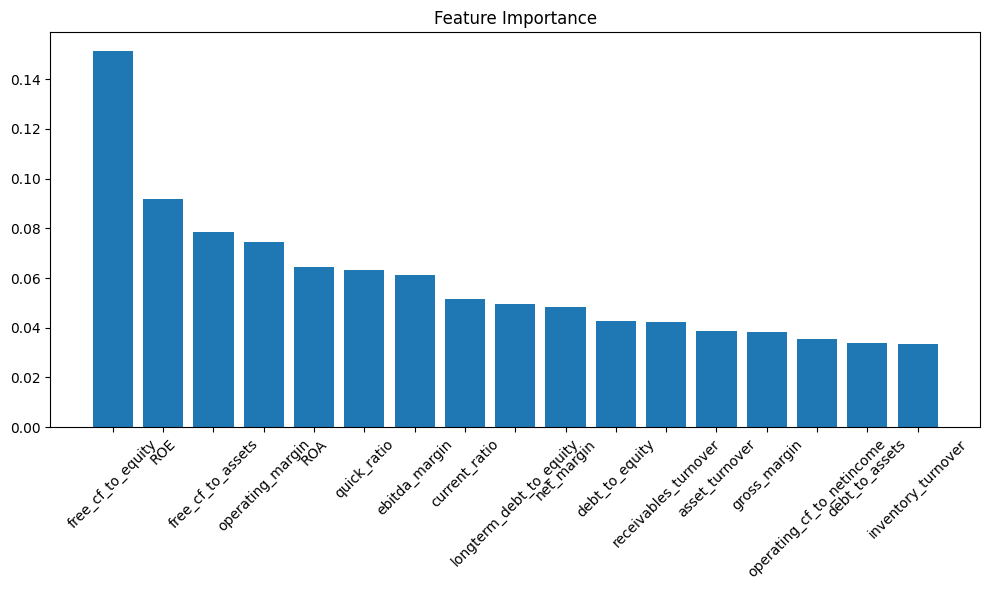

In [55]:
# Yeni hedef sütun
ranked_df['top10'] = (ranked_df['final_rank'] <= 10).astype(int)
# Özellikler (rasyolar)
X = ranked_df[ranking_metrics]

# Hedef değişken (ilk 10'a girme)
y = ranked_df['top10']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)

# Performans değerlendirmesi
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feat_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


In [57]:
# Özellik önemlerini pandas serisine çevir
importances = pd.Series(model.feature_importances_, index=ranking_metrics)

# Normalize edelim ki toplam 1 olsun (ağırlık toplamı)
weights = importances / importances.sum()
weighted_ranked_results = []

for idx, row in df4.iterrows():
    year = row['year']
    prev_year = year - 1
    tickers = row[1:].dropna().unique().tolist()

    df_year = combined_df[
        (combined_df['calendarYear'].astype(int) == prev_year) &
        (combined_df['symbol'].isin(tickers))
    ].copy()

    if df_year.empty:
        continue

    # Her metriğin sıralamasını hesapla
    for metric in ranking_metrics:
        if metric in df_year.columns:
            df_year[f"rank_{metric}"] = df_year[metric].rank(ascending=False, method='min')

    # Ağırlıklı toplam skoru hesapla
    weighted_score = 0
    for metric in ranking_metrics:
        rank_col = f"rank_{metric}"
        if rank_col in df_year.columns:
            weighted_score += df_year[rank_col] * weights[metric]

    df_year['weighted_score'] = weighted_score

    # Final sıralama
    df_year['final_weighted_rank'] = df_year['weighted_score'].rank(method='min')
    df_year['ranking_year'] = year

    weighted_ranked_results.append(df_year)

# Tüm yılları birleştir
weighted_ranked_df = pd.concat(weighted_ranked_results, ignore_index=True)
weighted_ranked_df = weighted_ranked_df.sort_values(by=['ranking_year', 'final_weighted_rank'])


In [62]:
# İlk 5 firmayı yıl bazlı karşılaştıralım
comparison = weighted_ranked_df.groupby('ranking_year').head(5)[
    ['ranking_year', 'symbol', 'final_weighted_rank']
]
comparison[comparison["ranking_year"]==2000]

,ranking_year,symbol,final_weighted_rank
25,2000,ADBE,1.0
3,2000,LLY,2.0
195,2000,CPB,3.0
71,2000,MO,4.0
137,2000,GIS,5.0


In [67]:
import yfinance as yf
import pandas as pd

def calculate_strategy_returns(ranked_df, rank_column='final_rank', top_n=20):
    portfolio_returns = []

    for year in range(2000, 2024):
        buy_date = f"{year}-04-01"
        sell_date = f"{year+1}-03-30"

        top = ranked_df[ranked_df['ranking_year'] == year].nsmallest(top_n, rank_column)
        tickers = top['symbol'].dropna().unique().tolist()

        if not tickers:
            continue

        try:
            # Verileri çek
            data = yf.download(tickers, start=buy_date, end=sell_date, progress=False)['Adj Close']

            # Tek sembolse Series olarak gelir → DataFrame yap
            if isinstance(data, pd.Series):
                data = data.to_frame()

            data = data.ffill().bfill()

            # En yakın tarihleri belirle
            buy_date_actual = min(data.index, key=lambda d: abs(pd.Timestamp(buy_date) - d))
            sell_date_actual = min(data.index, key=lambda d: abs(pd.Timestamp(sell_date) - d))

            # Fiyatları al
            buy_prices = data.loc[buy_date_actual]
            sell_prices = data.loc[sell_date_actual]

            # Return hesapla
            returns = (sell_prices / buy_prices) - 1
            avg_return = returns.mean()

            portfolio_returns.append({
                'year': year,
                'buy_date': str(buy_date_actual.date()),
                'sell_date': str(sell_date_actual.date()),
                'average_return': avg_return,
                'tickers': tickers
            })

        except Exception as e:
            print(f"{year} için veri alınamadı: {e}")
            continue

    return pd.DataFrame(portfolio_returns)


In [70]:
def download_prices_safe(tickers, start, end):
    collected_data = {}

    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start, end=end, progress=False)['Adj Close']
            if not df.empty:
                collected_data[ticker] = df
        except Exception as e:
            print(f"Failed to get {ticker}: {e}")
            continue

    return pd.DataFrame(collected_data)
def calculate_strategy_returns(ranked_df, rank_column='final_rank', top_n=20):
    portfolio_returns = []

    for year in range(2000, 2024):
        buy_date = f"{year}-04-01"
        sell_date = f"{year+1}-03-30"

        top = ranked_df[ranked_df['ranking_year'] == year].nsmallest(top_n, rank_column)
        tickers = top['symbol'].dropna().unique().tolist()

        if not tickers:
            continue

        try:
            price_data = download_prices_safe(tickers, buy_date, sell_date)

            if price_data.empty:
                print(f"{year} için hiç veri bulunamadı.")
                continue

            price_data = price_data.ffill().bfill()

            buy_date_actual = min(price_data.index, key=lambda d: abs(pd.Timestamp(buy_date) - d))
            sell_date_actual = min(price_data.index, key=lambda d: abs(pd.Timestamp(sell_date) - d))

            buy_prices = price_data.loc[buy_date_actual]
            sell_prices = price_data.loc[sell_date_actual]

            returns = (sell_prices / buy_prices) - 1
            avg_return = returns.mean()

            portfolio_returns.append({
                'year': year,
                'buy_date': str(buy_date_actual.date()),
                'sell_date': str(sell_date_actual.date()),
                'average_return': avg_return,
                'tickers_used': list(price_data.columns)
            })

        except Exception as e:
            print(f"{year} için genel hata: {e}")
            continue

    return pd.DataFrame(portfolio_returns)


In [71]:
# Klasik sıralama ile getiri
classic_results = calculate_strategy_returns(ranked_df, rank_column='final_rank')

# RF ağırlıklı sıralama ile getiri
rf_results = calculate_strategy_returns(weighted_ranked_df, rank_column='final_weighted_rank')



1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'FLR' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['FLR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['GIS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CPB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ADBE']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['LLY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MSFT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TROW']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get t

2000 için hiç veri bulunamadı.



1 Failed download:
['CPB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['USB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'CAR' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['CAR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['PNC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ADBE']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'DLX' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['DLX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'SLM' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SLM']: YFTzMi

2001 için hiç veri bulunamadı.


Failed to get ticker 'PLL' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['PLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ZBH']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'DLX' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['DLX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['GIS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'PCG' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['PCG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'SLM' re

2002 için hiç veri bulunamadı.



1 Failed download:
['PNC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CMA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ORCL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downloa

2003 için hiç veri bulunamadı.



1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'FHN' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['FHN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'LPX' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['LPX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['BAC']: J

2004 için hiç veri bulunamadı.



1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CMA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['KEY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WFC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download

2005 için hiç veri bulunamadı.



1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['KEY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['ADBE']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FITB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CMA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downl

2006 için hiç veri bulunamadı.



1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WFC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FITB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['HUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PNC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downloa

2007 için hiç veri bulunamadı.



1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['SPGI']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MTB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TROW']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed 

2008 için hiç veri bulunamadı.



1 Failed download:
['MO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['UPS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MTB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MCHP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AZO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['IBM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed do

2009 için hiç veri bulunamadı.



1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['NFLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['VRSN']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['JPM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WFC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['HSY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FITB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['IBM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['SPG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed

2010 için hiç veri bulunamadı.



1 Failed download:
['VRSN']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['NFLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BKNG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MTB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['HSY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed

2011 için hiç veri bulunamadı.


Failed to get ticker 'TRIP' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['TRIP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['UPS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['GILD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BKNG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WYNN']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CF']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MCD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed down

2012 için hiç veri bulunamadı.



1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ABBV']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BKNG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'TRIP' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['TRIP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['HSY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downl

KeyboardInterrupt: 

In [65]:
summary_df = pd.DataFrame({
    'year': classic_results['year'],
    'classic_avg_return': classic_results['average_return'].values,
    'rf_weighted_avg_return': rf_weighted_results['average_return'].values
})

summary_df['difference'] = summary_df['rf_weighted_avg_return'] - summary_df['classic_avg_return']
print(summary_df)

print("\nOrtalama Getiri (Classic):", summary_df['classic_avg_return'].mean())
print("Ortalama Getiri (RF Weighted):", summary_df['rf_weighted_avg_return'].mean())
print("Ortalama Getiri Farkı:", summary_df['difference'].mean())


KeyError: 'year'